In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,when
from pyspark.ml.feature import StringIndexer,StandardScaler,VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
import matplotlib.pyplot as plt
import seaborn  as sns

In [2]:
spark=SparkSession.builder.master("local").appName("fraud_detection").getOrCreate()
spark

26/01/07 02:48:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
df=spark.read.csv("farud_detectioncsv.csv",header=True, inferSchema=True)
df.show()

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M123070170

In [4]:
df = df.withColumn(
    "nameOrigClass",
    when(col("nameOrig").startswith("C"), "Customer")
    .when(col("nameOrig").startswith("M"), "Merchant")
) 


In [5]:
df = df.withColumn(
    "nameDestClass",
    when(col("nameDest").startswith("C"), "Customer")
    .when(col("nameDest").startswith("M"), "Merchant")
) 


In [6]:
indexer = StringIndexer(
    inputCol="nameDestClass",
    outputCol="nameDestClassEncoded"
) 

df = indexer.fit(df).transform(df)

In [7]:
indexer = StringIndexer(
    inputCol="nameOrigClass",
    outputCol="nameOrigClassEncoded"
) 

df = indexer.fit(df).transform(df)

In [8]:
indexer = StringIndexer(
    inputCol="type",
    outputCol="typeEncoded"
) 

df = indexer.fit(df).transform(df)

In [9]:
df=df.drop("nameOrigClass")
df=df.drop("nameDestClass")
df=df.drop("nameOrig")
df=df.drop("nameDest")
df=df.drop("type")
df.show()

+----+---------+-------------+--------------+--------------+--------------+-------+--------------+--------------------+--------------------+-----------+
|step|   amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|nameDestClassEncoded|nameOrigClassEncoded|typeEncoded|
+----+---------+-------------+--------------+--------------+--------------+-------+--------------+--------------------+--------------------+-----------+
|   1|  9839.64|     170136.0|     160296.36|           0.0|           0.0|      0|             0|                 1.0|                 0.0|        1.0|
|   1|  1864.28|      21249.0|      19384.72|           0.0|           0.0|      0|             0|                 1.0|                 0.0|        1.0|
|   1|    181.0|        181.0|           0.0|           0.0|           0.0|      1|             0|                 0.0|                 0.0|        3.0|
|   1|    181.0|        181.0|           0.0|       21182.0|           0.0|      1

In [10]:
col_name=['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
          'newbalanceDest', 'isFlaggedFraud', 'nameDestClassEncoded',"nameOrigClassEncoded","typeEncoded"]
assembler = VectorAssembler(
    inputCols=col_name,
    outputCol="features"
)

df = assembler.transform(df)

In [11]:
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)

df = scaler.fit(df).transform(df)


In [12]:
df.select("features", "scaledFeatures").show()

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[1.0,9839.64,1701...|[-1.6620211124164...|
|[1.0,1864.28,2124...|[-1.6620211124164...|
|(10,[0,1,2,9],[1....|[-1.6620211124164...|
|(10,[0,1,2,4],[1....|[-1.6620211124164...|
|[1.0,11668.14,415...|[-1.6620211124164...|
|[1.0,7817.71,5386...|[-1.6620211124164...|
|[1.0,7107.77,1831...|[-1.6620211124164...|
|[1.0,7861.64,1760...|[-1.6620211124164...|
|(10,[0,1,2,7,9],[...|[-1.6620211124164...|
|[1.0,5337.77,4172...|[-1.6620211124164...|
|[1.0,9644.94,4465...|[-1.6620211124164...|
|[1.0,3099.97,2077...|[-1.6620211124164...|
|[1.0,2560.74,5070...|[-1.6620211124164...|
|(10,[0,1,2,7,9],[...|[-1.6620211124164...|
|[1.0,4098.78,5032...|[-1.6620211124164...|
|(10,[0,1,2,4,5],[...|[-1.6620211124164...|
|(10,[0,1,2,7,9],[...|[-1.6620211124164...|
|[1.0,1157.86,2115...|[-1.6620211124164...|
|[1.0,671.64,15123...|[-1.6620211124164...|
|(10,[0,1,2,4,9],[...|[-1.662021

In [13]:
lr = LogisticRegression(
    featuresCol="scaledFeatures",  
    labelCol='isFraud',
    maxIter=20
)

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


In [14]:
model=lr.fit(train_df)
predictions=model.transform(test_df)
predictions.select("scaledFeatures", "isFraud", "prediction", "probability").show(5)

26/01/07 02:48:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 74:>                                                         (0 + 1) / 1]

+--------------------+-------+----------+-----------+
|      scaledFeatures|isFraud|prediction|probability|
+--------------------+-------+----------+-----------+
|[-1.6620211124164...|      0|       0.0|  [1.0,0.0]|
|[-1.6620211124164...|      0|       0.0|  [1.0,0.0]|
|[-1.6620211124164...|      0|       0.0|  [1.0,0.0]|
|[-1.6620211124164...|      0|       0.0|  [1.0,0.0]|
|[-1.6620211124164...|      0|       0.0|  [1.0,0.0]|
+--------------------+-------+----------+-----------+
only showing top 5 rows


In [15]:
predictionAndLabels = predictions.select("prediction", "isFraud") \
                                 .rdd.map(lambda row: (float(row[0]), float(row[1])))

metrics = MulticlassMetrics(predictionAndLabels)
cm = metrics.confusionMatrix().toArray()


/opt/spark/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
                                                                                

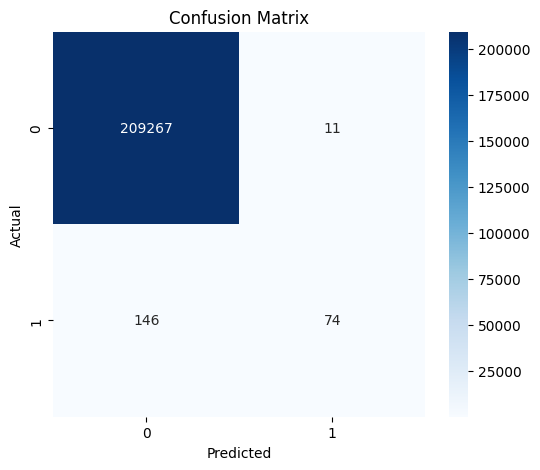

In [16]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [18]:
model.save("logistic_regression_model")